## 처리 순서
1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성합니다.

## 모듈정리

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

## 모델 불러오기

In [2]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fe7f45bf0a0>)

## 인물사진  함수 만들기

In [3]:
def seg_func(img_path, img_orig, model_file, class_name): # 사용할 이미지, 모델, 클래스 
    
    """
    img_path : 이미지 경로
    model_file : 사용할 모델
    class_name : 효과를 적용할 클래스 이름  ex) person, cat
    """
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    # 모델에 적용가능한 클래스
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    print(f'모델에서 검열 가능한 클래스들 : {LABEL_NAMES}')

    # 사진에 포함된 클래스 확인
    print('사진에 포함된 클래스 확인 ')
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
        
    print('검출한 클래스 시각화')    
    plt.imshow(output)
    plt.show()
    
   # 클래스별 색상 코드 찾기
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    # 내가 찾고싶은 클래스의 색상코드 
    colormaps = colormap[LABEL_NAMES.index(class_name)]
    seg_color = (colormaps[2],colormaps[1],colormaps[0])
    
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    print('인물과 그외 다른 클래스 0,1로 분리')
    seg_map = np.all(output==seg_color, axis=-1)
    print(seg_map.shape)
    
    plt.imshow(seg_map, cmap='gray')
    plt.show()
    
    print('원본 이미지와 겹쳐서 세그멘테이션 결과 확인 ')
    img_show = img_orig.copy()
    
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # (13,13)은 blurring kernel size를 뜻합니다
    # 다양하게 바꿔보세요
    print('블러 처리')
    img_orig_blur = cv2.blur(img_orig, (20,20))  
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print('배경만 따기')
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print('세그멘테이션한 결과물 합성')
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

## 이미지 가져오기

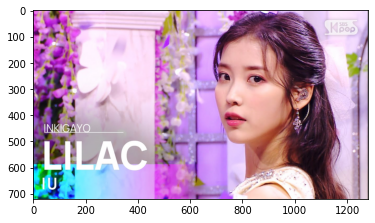

In [4]:
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/아이유.png'  
img_orig1 = cv2.imread(img_path1) 

# print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

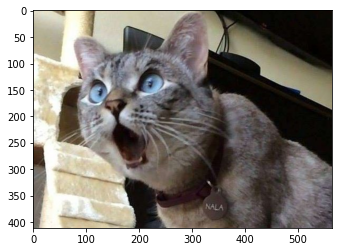

In [5]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.png'  
img_orig2 = cv2.imread(img_path2) 

# print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

## 인물사진 함수 적용

모델에서 검열 가능한 클래스들 : ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
사진에 포함된 클래스 확인 
background
person
검출한 클래스 시각화


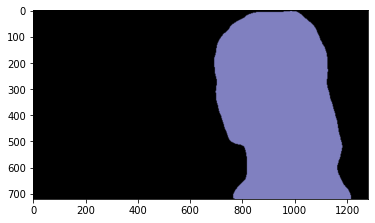

인물과 그외 다른 클래스 0,1로 분리
(720, 1280)


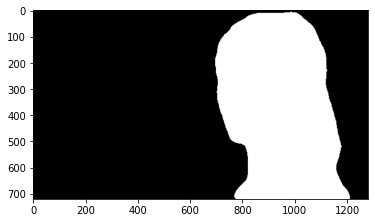

원본 이미지와 겹쳐서 세그멘테이션 결과 확인 


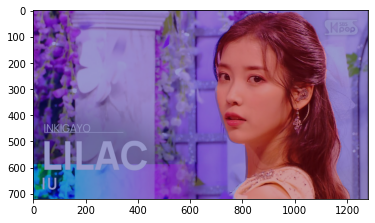

블러 처리


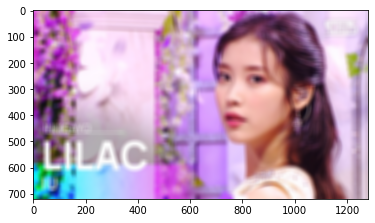

배경만 따기


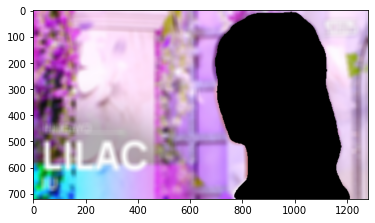

세그멘테이션한 결과물 합성


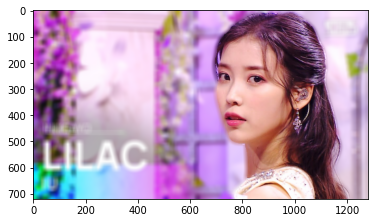

In [6]:
seg_func(img_path1,img_orig1,model_file,'person')

모델에서 검열 가능한 클래스들 : ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
사진에 포함된 클래스 확인 
background
cat
검출한 클래스 시각화


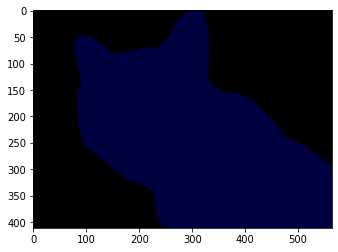

인물과 그외 다른 클래스 0,1로 분리
(411, 564)


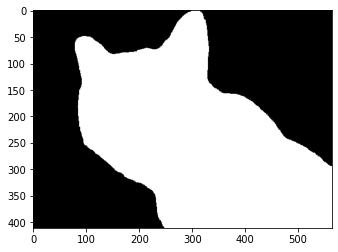

원본 이미지와 겹쳐서 세그멘테이션 결과 확인 


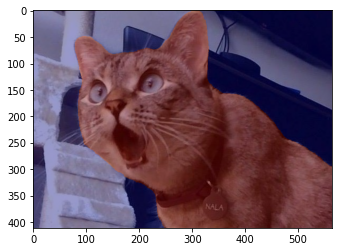

블러 처리


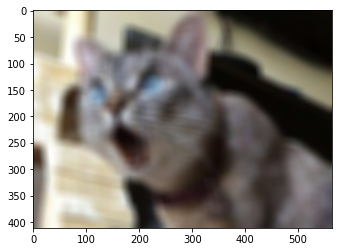

배경만 따기


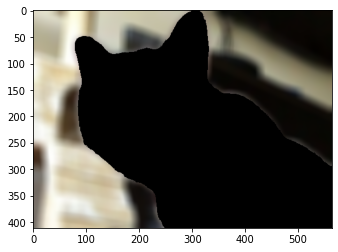

세그멘테이션한 결과물 합성


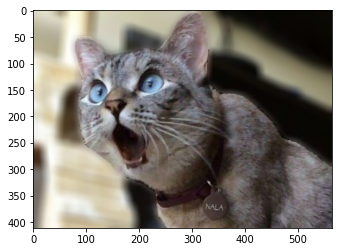

In [7]:
seg_func(img_path2,img_orig2,model_file,'cat')

## 크로마키 하기

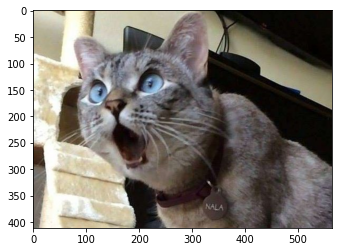

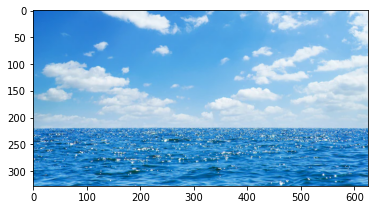

In [8]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.png'  
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/바다.png'  
img_orig3 = cv2.imread(img_path3) 
img_crmk = cv2.imread(img_path4) 

# print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

# print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_crmk, cv2.COLOR_BGR2RGB))
plt.show()

## 크로마키 함수 만들기

In [9]:
def crmk_func(img_path, img_orig, img_crmk, model_file, class_name): # 사용할 이미지, 모델, 클래스 
    
    """
    img_path : 이미지 경로
    model_file : 사용할 모델
    class_name : 효과를 적용할 클래스 이름  ex) person, cat
    """
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    # 모델에 적용가능한 클래스
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    print(f'모델에서 검열 가능한 클래스들 : {LABEL_NAMES}')

    # 사진에 포함된 클래스 확인
    print('사진에 포함된 클래스 확인 ')
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
        
    print('검출한 클래스 시각화')    
    plt.imshow(output)
    plt.show()
    
   # 클래스별 색상 코드 찾기
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    # 내가 찾고싶은 클래스의 색상코드 
    colormaps = colormap[LABEL_NAMES.index(class_name)]
    seg_color = (colormaps[2],colormaps[1],colormaps[0])
    
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    print('인물과 그외 다른 클래스 0,1로 분리')
    seg_map = np.all(output==seg_color, axis=-1)
    print(seg_map.shape)
    
    plt.imshow(seg_map, cmap='gray')
    plt.show()
    
    print('원본 이미지와 겹쳐서 세그멘테이션 결과 확인 ')
    img_show = img_orig.copy()
    
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # (13,13)은 blurring kernel size를 뜻합니다
    # 다양하게 바꿔보세요
    print('크로마키 처리')
    img_orig_crmk = cv2.resize(img_crmk, dsize=(seg_map.shape[1],seg_map.shape[0]), interpolation=cv2.INTER_AREA)
    plt.imshow(cv2.cvtColor(img_orig_crmk, cv2.COLOR_BGR2RGB))
    plt.show()
                        
    print('배경만 따기')
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_crmk = cv2.bitwise_and(img_orig_crmk, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_crmk, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print('세그멘테이션한 결과물 합성')
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_crmk)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

## 크로마키 적용

모델에서 검열 가능한 클래스들 : ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
사진에 포함된 클래스 확인 
background
cat
검출한 클래스 시각화


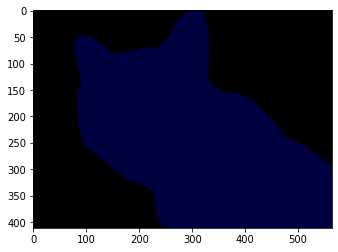

인물과 그외 다른 클래스 0,1로 분리
(411, 564)


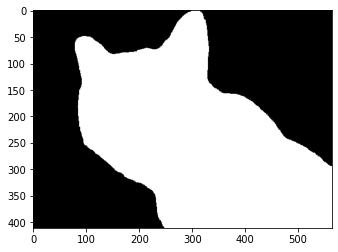

원본 이미지와 겹쳐서 세그멘테이션 결과 확인 


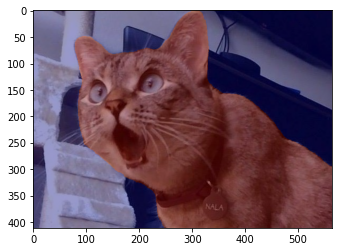

크로마키 처리


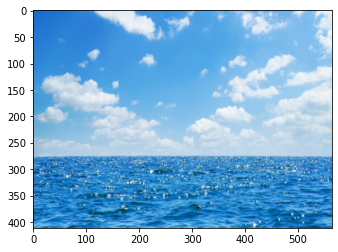

배경만 따기


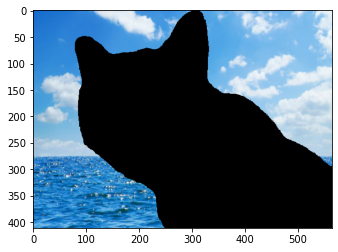

세그멘테이션한 결과물 합성


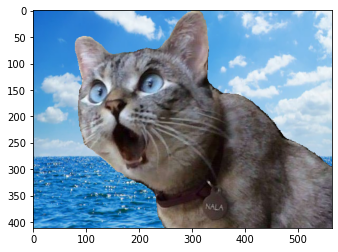

In [10]:
crmk_func(img_path3,img_orig3,img_crmk,model_file,'cat')

## 회고 

### 평가문항

1. 인물모드 사진을 성공적으로 제작하였다.
    - 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
    - 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
    
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
    - 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.
    
### 평가 문항 체크

1. 인물모드,고양이,크로마키 모두 문제 없이 성공하였다. 

2. 이미지의 형태를 완벽하게 못땀.

## 인물 사진
<img src="캡처1.PNG">

## 고양이 사진
<img src="고양이.PNG">

3. 모델의 정확도를 개선하기위한 솔루션은 찾지못하였다.
    
